# An Approach to Content Based Recommendation

## Introduction

For a business, recommendation systems are incredibly valuable. They can have a direct impact on revenue and can greatly improve user experience. They also provide many interesting challenges to the data scientists and engineers along the lines of scalability and performance. People are likely already thinking about using machine learning (ML) to predict a label based on an item title and/or description. During this process, features are actually being created that could arguably be leveraged in your content based recommender system.

Content based recommendation systems can add a lot of value in two main scenarios.

- Having a large number of items, each with little individual traffic.
- Having dyanmic items that don't have a ton of interactions.

If you have high traffic, or a lot of historical data, and your items change slowly, a user interaction model will probably provide the strongest solution. However, in the cases noted above, you may want to focus on having a solid content based system.

In this post, I'll show how we can leverage a neural network to predict the category of text data - for this, I'll be using the [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset. Further, I'll show and argue for an architecture that gives us learned feature representation (embedding) that can be easily used to make content based recommendations. In the next few sections you'll see a brief description and exploration of the data (train and test). I'll then go into the data preprocessing pipeline and modeling of the data. We will then look at the basic model performance. Finally, we will look at the use of embeddings for finding similar content.
<!-- TEASER_END --> 
 
Just as a brief note, about choosing the tooling/techniques. My general feeling is to use the best tool for the job, and to think a little about your timeline. There are so many ways to approach this sort of problem, and they are all going to give (likely) good results. But in this case, and for many things, its good to think about the future of your system - avoiding choices, for as long as possible, that remove flexibility or limit change later. Some of the major advantages I see with this method lie in the neural network (NN), as they are very flexible and scale to large volumes of data extrememly well. But at the end of the day, I'll still go with - pick the best tool for the job. The 20 Newsgroups dataset is not large by any means, so the use of a NN is somewhat overkill, but this is more to demonstrate good practices for more production scale problems.

In [79]:
# collab installs
!pip3 install sentencepiece

In [0]:
# Standard Library
from typing import List, Tuple, Callable
import copy
import os

# Requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
from sklearn import datasets
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import keras.layers as L
import keras.models as M
from keras.preprocessing.text import Tokenizer  # in case we want to explore this tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize": (12, 6),
        "font.size": 14,
    }
)
np.random.seed(89)

## 20 Newsgroups (The Data)

The [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset is a fairly popular text dataset comprised of about 20,000 documents, each having a label/category. In general, the documents are formatted sort of like emails - where they have subjects, email addresses, and occasionally responses embedded in them (in some ways this is meta-data).
 
In some cases you'd spend a decent amount of time deliberating on the training data, and what you'd want to keep - what will improve generalization, or not, depending on your goal.

For this post, I have decided to remove all of the data in the headers and footers to improve generalization. Leaving in the headers and footers, are arguably inflating accuracy numbers as they can reference the topic directly, show an email address, which adds data leakage and hinders the generalization of the model.

We will also be looking at some brief analysis of the text. If this is where we would spend the majority of our time, but as this is a document that is a bit more focused on methodology and process, I'll be doing slightly less here in the interest of time.
 
We will leverage the sklearn api to get some insights into our data.


## EDA

### Download

In [0]:
random_state = 89
remove = ('headers', 'footers')
# remove = ()

sample = datasets.twenty_newsgroups.fetch_20newsgroups(subset="train", random_state=random_state)
sample = sample.data[1]

train = datasets.twenty_newsgroups.fetch_20newsgroups(subset="train", random_state=random_state, remove=remove)
test = datasets.twenty_newsgroups.fetch_20newsgroups(subset="test", random_state=random_state, remove=remove)

### Eamples

#### Full

In [82]:
print(sample)

From: tpremo@mentor.cc.purdue.edu (Cinnamon Bear)
Subject: Onkyo Integra series Integrated amp for sale:
Organization: Purdue University Computing Center
Distribution: na
Lines: 18

I have a Onkyo integrated amplifier that I am looking to get rid of.
	60w/ch
	works great
	Integra series
	not a problem

	Asking $100 OBO

	If your interested call me at 317-743-2656  or email this address.
	MAKE ME AN OFFER!!!

Todd

-- 
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 (___________________________________ %   Todd Premo  
         /              /      /      %   Purdue Universtiy 
       /    __	 __   / __   /        %   Environmental Engineering 



### Cleaned

In [83]:
print(train.data[1])

I have a Onkyo integrated amplifier that I am looking to get rid of.
	60w/ch
	works great
	Integra series
	not a problem

	Asking $100 OBO

	If your interested call me at 317-743-2656  or email this address.
	MAKE ME AN OFFER!!!

Todd



### Topics

In [84]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [85]:
train_vec = CountVectorizer(stop_words='english')
train_counts = train_vec.fit_transform(train.data)
train_vocab = np.array(train_vec.get_feature_names())


test_vec = CountVectorizer(stop_words='english')
test_counts = test_vec.fit_transform(test.data)
test_vocab = np.array(test_vec.get_feature_names())

# (documents, total 'words' or vocab)
print(train_counts.shape, test_counts.shape)

(11314, 114441) (7532, 81373)


### Most Common Words 

Let's take a look at some of the most common words in each document. Below you will see the word with the largest count, and it document category.

In [86]:
most_common = list(zip(
    train_vocab[np.asarray(np.argmax(train_counts, axis=1)).T[0]],
    np.asarray(np.max(train_counts, axis=1).data).T,
    np.array(train.target_names)[train.target]
))[10:20]

print("Term | Count | Document Category")
print("------------------------")
for w,s,c in most_common:
    print(f"{w} | {s:0.2f} | {c}")

Term | Count | Document Category
------------------------
mac | 3.00 | comp.sys.mac.hardware
books | 2.00 | sci.space
does | 3.00 | sci.crypt
accuracy | 1.00 | sci.electronics
runs | 4.00 | rec.sport.baseball
police | 9.00 | sci.crypt
application | 5.00 | comp.os.ms-windows.misc
does | 3.00 | comp.sys.mac.hardware
ahmadiyya | 13.00 | soc.religion.christian
ford | 3.00 | rec.autos


### Document Stats

Some major things to note below will be the number of words in each document on average - so we can get an idea of how long training sequence should be. We should also pay attention to the number of unique tokens that we counted above to get a ballpark of the vocabulary size we'll want to train with.

In [0]:
def describe_docs(
    train: np.array,
    test: np.array,
    max_bin: int = 2000,
    n_bins: int = 100,
    show: bool = True,
    xlabel: str = "",
    ylabel: str = "P"
) -> None:
    """
    A basic plotting helper fuction.

    Args:
        ``train`` (`np.array`): A list of integers to histogram.
        ``test`` (`np.array`): A list of integers to histogram.
        ``max_bin`` (`int`, optional, default is 2000): The max bin
        of the histogram
        ``n_bins`` (`list`, optional, default is 100): The number of
        bins for the histogram.
        ``show`` (`bool`, optional, default is True): Show the plot if True. 
    """
    bins = np.linspace(0, max_bin, n_bins)

    summary = f"""
    Number of Documents:
        - Train: {len(train)}
        - Test: {len(test)} 
    Fraction over max bin:
        - Train: {np.sum(train > max_bin) / len(train)}
        - Test: {np.sum(test > max_bin) / len(test)}
    Mean:
        - Train {np.mean(train)}
        - Test {np.mean(test)}
    Median:
        - Train {np.median(train)}
        - Test {np.median(test)}
    """

    fig, ax = plt.subplots()
    ax.hist(train, bins, label="Train", alpha=0.5, density=True)
    ax.hist(test, bins, label="Test", alpha=0.5, density=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(loc="best")
    if show:
        plt.show()
    print(summary)

#### Total Words per Document

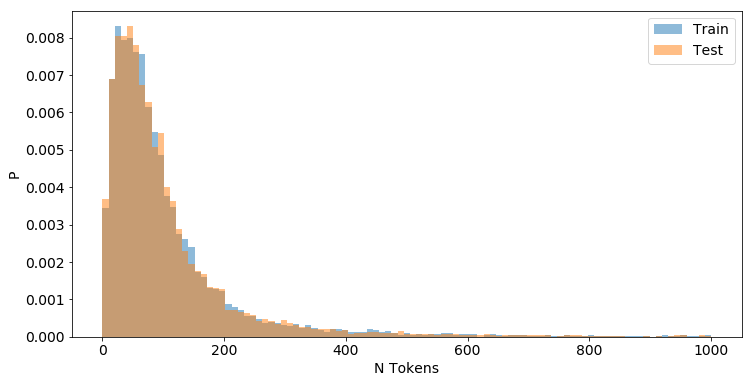


    Number of Documents:
        - Train: 11314
        - Test: 7532 
    Fraction over max bin:
        - Train: 0.012462435920098993
        - Test: 0.009426447158789167
    Mean:
        - Train 141.9094042778858
        - Test 126.40095592140202
    Median:
        - Train 71.0
        - Test 71.0
    


In [88]:
describe_docs(
    np.asarray(np.sum(train_counts, axis=1).T)[0],
    np.asarray(np.sum(test_counts, axis=1).T)[0],
    max_bin=1000,
    xlabel="N Tokens"
)

#### Unique Words per Document

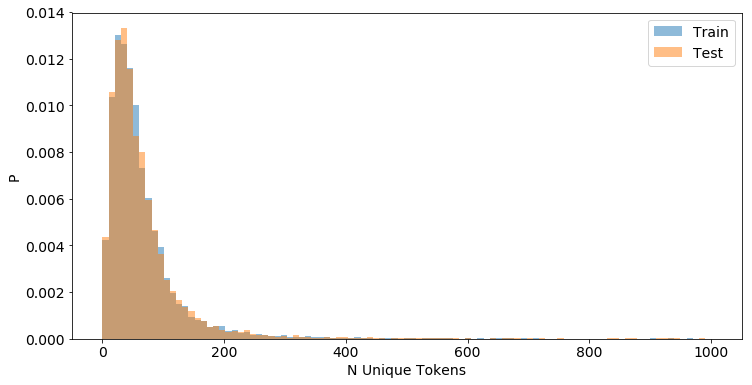


    Number of Documents:
        - Train: 11314
        - Test: 7532 
    Fraction over max bin:
        - Train: 0.002386423899593424
        - Test: 0.0009293680297397769
    Mean:
        - Train 70.75941311649284
        - Test 68.84227296866702
    Median:
        - Train 48.0
        - Test 48.0
    


In [89]:
describe_docs(
    np.asarray(np.sum(train_counts == 1, axis=1).T)[0],
    np.asarray(np.sum(test_counts == 1, axis=1).T)[0],
    max_bin=1000,
    xlabel="N Unique Tokens"
)

#### Average Number of Words per Document by Category

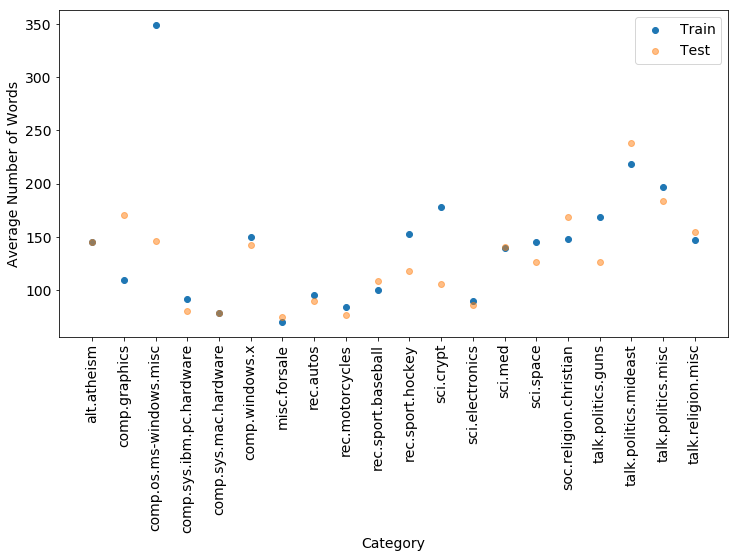

In [90]:
train_sum = np.asarray(np.sum(train_counts, axis=1)).T[0]
test_sum = np.asarray(np.sum(test_counts, axis=1)).T[0]
train_df = pd.DataFrame({
    'target': train.target,
    'target_name': np.array(train.target_names)[np.array(train.target)],
    'n_words': train_sum
})

test_df = pd.DataFrame({
    'target': test.target,
    'target_name': np.array(test.target_names)[np.array(test.target)],
    'n_words': test_sum
})

train_grp = train_df.groupby('target_name').mean().reset_index()
test_grp = test_df.groupby('target_name').mean().reset_index()

fig, ax = plt.subplots()
ax.scatter(train_grp.target_name, train_grp.n_words, label='Train')
ax.scatter(test_grp.target_name, test_grp.n_words, label='Test', alpha=0.5)
ax.set_xlabel("Category")
ax.set_ylabel("Average Number of Words")
for label in ax.get_xticklabels():
    label.set_rotation("vertical")
plt.legend(loc="best")

### Topic Distribution

We should also look at the label balance between train and test. In effect, we want our test dataset to be of similar composition to our training dataset - and both should reflect the problem that we are trying to solve. In the case of this dataset we can see that the train/test split is evenly balanced with similar fractions/distributions of labels between the two sets.

In [91]:
train_targets, train_count = np.unique(train.target, return_counts=True)
test_targets, test_count = np.unique(test.target, return_counts=True)
frac_train = train_count / np.sum(train_count)
frac_test = test_count / np.sum(test_count)

for i in range(len(train_targets)):
    target = train.target_names[train_targets[i]]
    train_f = frac_train[i]
    test_f = frac_test[i]

    print(f"""
    {target}:
        Train: {train_f:.02f}
        Test: {test_f:.02f}
    """)
    


    alt.atheism:
        Train: 0.04
        Test: 0.04
    

    comp.graphics:
        Train: 0.05
        Test: 0.05
    

    comp.os.ms-windows.misc:
        Train: 0.05
        Test: 0.05
    

    comp.sys.ibm.pc.hardware:
        Train: 0.05
        Test: 0.05
    

    comp.sys.mac.hardware:
        Train: 0.05
        Test: 0.05
    

    comp.windows.x:
        Train: 0.05
        Test: 0.05
    

    misc.forsale:
        Train: 0.05
        Test: 0.05
    

    rec.autos:
        Train: 0.05
        Test: 0.05
    

    rec.motorcycles:
        Train: 0.05
        Test: 0.05
    

    rec.sport.baseball:
        Train: 0.05
        Test: 0.05
    

    rec.sport.hockey:
        Train: 0.05
        Test: 0.05
    

    sci.crypt:
        Train: 0.05
        Test: 0.05
    

    sci.electronics:
        Train: 0.05
        Test: 0.05
    

    sci.med:
        Train: 0.05
        Test: 0.05
    

    sci.space:
        Train: 0.05
        Test: 0.05
    

    soc.religion.c

## Tokenization

Our goal here is to turn the text into a sequence of integers (or values) that can be used to train a model. Classically, we've seen this done (with things above, even) with techniques like counts of words, or tf-idf. But in this case we want to assume there is some information in order they are presented. So, we will be using a tokenizer that turns words into integers.
 
When starting to dig around here, there are many ways to do this. Keras has a great with with their Tokenizer. However, there are some kinds of limitations here - especially around language, where some languages don't use whitespace the same way English does, and you lose the ability to convert the sentence fully back to its original form - it is lossy.
 
So, in this post we will test out another technique, put out by Google, called [SentencePiece](https://github.com/google/sentencepiece). You should read the paper, but essentially the reason I'm so interested in this is that is does 'lossless tokenization' and provides a method for us to not depend on language-specific pre/post-processing. Again, we are hitting on a general theme to this document, trying to be as flexible as possible. Using SentencePiece allows us to connect back to the large vocabulary problem. If we look at all words individually, we don't get any predictive power from something that is not in our vocabulary. For example, if we are just using unique terms, we don't get any predictive power from something like "applepie" even if "apple" and "pie" are both in your vocabulary.
 
To use this we need to train it on our corpus - there is likely some optimization we could do here with the number of tokens to generate, but for now, we'll just set a 'reasonable' number and come back to tune this later.
 
[SentencePiece code usage reference](https://colab.research.google.com/drive/1rQ0tgXmHv02sMO6VdTO0yYaTvc1Yv1yP#scrollTo=HQGC3TTEjFuN)


In [0]:
VOCAB_SIZE = 60000

In [0]:
tok = Tokenizer(num_words=VOCAB_SIZE)
tok.fit_on_texts(train.data)

In [0]:
corpus = ""
for d in train.data:
  corpus += " "
  corpus += d

with open("20-newsgroups-train.txt", "w") as f:
  f.write(corpus)

In [95]:
model_prefix = f"m{VOCAB_SIZE}"
model_name = f"{model_prefix}.model"
if not os.path.exists(model_name):
    spm.SentencePieceTrainer.train(f"--model_prefix={model_prefix} --input=20-newsgroups-train.txt --vocab_size={VOCAB_SIZE}")

sp = spm.SentencePieceProcessor()
sp.load(model_name)

True

## Data Preprocessing

Set up a basic pipeline to pre-process the data. Here I'm using a sort of pipeline method where I can set up a list of transformations I'd like to apply to the data. These should be easy to write/replace and allow for quick iteration to our data prep/processing pipeline. It's not the most important for this particular case, but I've found it to be a very useful pattern when dealing with images and loading from a directory.

The data preprocessing is consists of 2 steps here - which, I hope, are pretty apparent in the code.

1. Tokenize the data (turn strings to ints)
2. Pad/clip each sequence to the max doc length.

We should note here that this is not a bag of words type of model but is actually going to be preserving sentence structure, giving our model more context and hopefully more predictive power. This formulation is great for a neural network but would not perform well with a linear model (or something similar). This formulation is another advantage to neural networks, allowing us learn from the sequence structure of sentences.

In [0]:
def tokenize_vec(fcn: callable) -> Callable[[list], list]:
    """
    If your tokenizer can do all documents at one time use this function.

    Args:
        ``fcn`` (`callable`): The function you'd like to tokenize the
        documents with.
    
    Returns:
        ``callable``: Takes a list of documents.
    """
    def _tokenize(documents: List[str]):
        return fcn(documents)
    return _tokenize


def tokenize(fcn: callable) -> Callable[[list], list]:
    """
    If your tokenizer can only tokenize one doc at a time.

    Args:
        ``fcn`` (`callable`): The function you'd like to tokenize the
        documents with.
    
    Returns:
        ``callable``: Takes a list of documents.
    """
    def _tokenize(documents: List[str]):
        tokens = []
        for d in documents:
            tokens.append(fcn(d))
        return tokens
    return _tokenize


def pad_clip_sequence(
    maxlen: int = 200,
    padding: str ='pre',
    truncating: str = 'pre',
    value: int = 0
) -> Callable[[List[int]], np.array]:
    """
    Use Keras's `pad_sequences` function to augment your input sequences.

    Args:
        ``maxlen`` (`int`, optional, default 200): Max length of a doc - will
        clip or pad to this.
        ``padding`` (`str`, optional, default `pre`): Pad at the front or back
        of sequence. Options are [`pre`, `post`],
        ``truncating`` (`str`, optional, default `pre`): Cut at the front or
        back of sequence. Options are [`pre`, `post`]
        ``value`` (`int`, optional, default 0): The value to pad with.

    Returns:
        `callable`: Callable takes your list of sequences to give appropriate
        shape.
    """
    def _pad(seqs: List[int]) -> np.array:
        return pad_sequences(
            seqs,
            maxlen=maxlen,
            padding=padding,
            truncating=truncating,
            value=value
        )
    return _pad


def build_pipeline(data: list, steps: list) -> np.array:
    data = copy.deepcopy(data)
    for step in steps:
        data = step(data)
    return data

  
MAX_DOC_LEN = 500

data_prep_pipeline = [
    # tokenize_vec(tok.texts_to_sequences),
    tokenize(sp.encode_as_ids),
    pad_clip_sequence(MAX_DOC_LEN),
]


In [97]:
prepped_train = build_pipeline(train.data, data_prep_pipeline)
prepped_train.shape

(11314, 500)

In [98]:
prepped_test = build_pipeline(test.data, data_prep_pipeline)
prepped_test.shape

(7532, 500)

## Modeling

As noted above, I want to pitch an architecture that gives us a model that can predict the target variable, but in the process allow us some sort of extra model that can give us informative features, in a lower dimensional space, that we can later use for finding similar documents (recommendations).
 
Here we are going to effectively create 2 models. A model for the embedding, or the embedding network, and a model for the training, our actual model. In many cases with embedding sorts of models you will tend to throw away the model that actually did the training of the embedding (think siamese networks and the like). In this case we actually want our main model and are just getting the embedding as a bonus, an artifact of how we've chosen to tackle the problem. In the latter part of this notebook we will actually hijack the embedding network and use the learned representations to do content based recommendation.
 
Below you will see two functions that each create models. The embedding network, is where we will try to put most of the weight, we want this portion to be robust and produce features that lead to solid classification accuracy. Our training network should be pretty light - except that it contains the embedding - and we'll only add a layer to make the output shape correct and have the softmax activation act on it. Embeddings are become somewhat of a standard practice in machine learning. They allow us to encode large vocabularies (vocabulary here could be anything that you could map to a unique integer) to dense vectors. The keras embedding layer does this for us really well and is trainable; similar items can be embedded into a similar space. Here, I've added a 1d convolution after the embedding to help learn from nearby words in each document, giving our model knowledge of the sentence structure.
 
Additionally, these networks could likely improve with some tuning, in terms of dropout, number, size, and shape of layers, and regularization. I have put a 'simple' architecture here that gives decent performance - but a little more time could likely improve the results considerably.


In [0]:
def create_embedding_network(
    input_dim: tuple = (500,),
    output_dim: int = 256, 
    embedding_input_dim: int = 20000,
    embedding_output_dim: int = 64,
    inner_activation: str = "relu"
):
  x_in = L.Input(input_dim)
  x = x_in
  
  emb = L.Embedding(
      embedding_input_dim,
      embedding_output_dim,
      trainable=True,
  )
  x = emb(x)
  x = L.Dropout(rate=0.5)(x)

  x = L.BatchNormalization()(x)
  x = L.Conv1D(output_dim, 3, activation=inner_activation)(x)
  x = L.Dropout(rate=0.5)(x)

  x = L.GlobalAveragePooling1D()(x)
  
  return M.Model(inputs=x_in, outputs=x)



def create_network(
    embedding: M.Model,
    input_dim: tuple = (200,),
    output_dim: int = 20,
    inner_activation: str = "relu",
    output_activation: str = "softmax"
):
  x_in = L.Input(input_dim)
  x = x_in
  x = embedding(x)
  x = L.Dropout(rate=0.5)(x)
  x = L.Dense(output_dim, activation=output_activation)(x)

  return M.Model(inputs=x_in, outputs=x)


## Training

In [0]:
n_epochs = 25

embedding = create_embedding_network(
    input_dim=(MAX_DOC_LEN,),
    output_dim=32,
    embedding_output_dim=32,
    embedding_input_dim=VOCAB_SIZE
)
model = create_network(embedding, input_dim=(MAX_DOC_LEN,))

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [101]:
embedding.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 32)           1920000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 500, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 498, 32)           3104      
_________________________________________________________________
dropout_8 (Dropout)          (None, 498, 32)           0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0   

In [102]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 500)               0         
_________________________________________________________________
model_5 (Model)              (None, 32)                1923232   
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                660       
Total params: 1,923,892
Trainable params: 1,923,828
Non-trainable params: 64
_________________________________________________________________


Batch size tends to have a big impact - with this architecture I've found that a batch size of 256 give reasonably good performance.

In [103]:
fit_history = model.fit(prepped_train, train.target, batch_size=256, epochs=n_epochs, validation_data=(prepped_test, test.target))

Train on 11314 samples, validate on 7532 samples
Epoch 1/25
11314/11314 [==============================] - 2s 197us/step - loss: 3.0250 - acc: 0.0611 - val_loss: 2.9580 - val_acc: 0.0921
Epoch 2/25
11314/11314 [==============================] - 1s 113us/step - loss: 2.9445 - acc: 0.0865 - val_loss: 2.9021 - val_acc: 0.2265
Epoch 3/25
11314/11314 [==============================] - 1s 114us/step - loss: 2.8401 - acc: 0.1398 - val_loss: 2.7608 - val_acc: 0.2946
Epoch 4/25
11314/11314 [==============================] - 1s 112us/step - loss: 2.6538 - acc: 0.2059 - val_loss: 2.5307 - val_acc: 0.4468
Epoch 5/25
11314/11314 [==============================] - 1s 113us/step - loss: 2.4133 - acc: 0.2827 - val_loss: 2.2621 - val_acc: 0.5556
Epoch 6/25
11314/11314 [==============================] - 1s 113us/step - loss: 2.1315 - acc: 0.3810 - val_loss: 2.0064 - val_acc: 0.6371
Epoch 7/25
11314/11314 [==============================] - 1s 113us/step - loss: 1.9115 - acc: 0.4488 - val_loss: 1.7837 - v

### Training Insights

Our plots below look totally reasonable. There are no obvious signs of overfitting - our loss is not ramping back up on the test set - and our accuracy is totally reasonable.

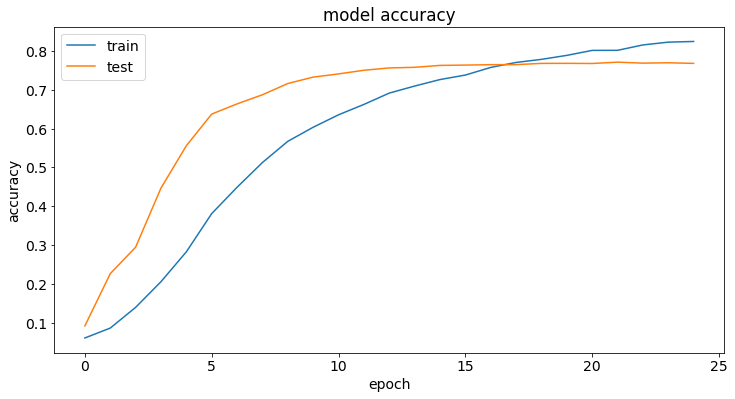

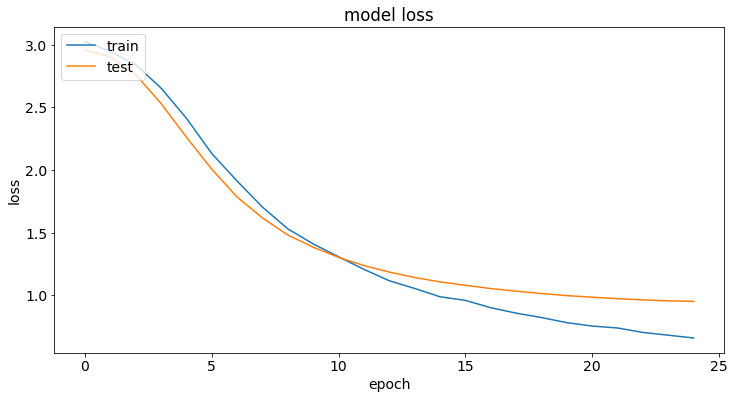

In [104]:
fig, ax = plt.subplots()
ax.plot(fit_history.history['acc'])
ax.plot(fit_history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig, ax = plt.subplots()
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Validation

Validation is key for any data science project, you should always pick the right metric for determining the success of your model. You should also consider the business use case if you are in that situation. Here, I'm choosing to use the F1 score as this seems to be fairly standard and gives a nice baseline when comparing to other results.
 
You'll notice I pass in `macro` as the averaging parameter because we have balanced labels and I'd like to know more about how we are doing on a per category basis.

In [105]:
# F1 Score
y_pred = np.argmax(model.predict(prepped_test), axis=1)
f1 = f1_score(y_pred, test.target, average='macro')

print(f"F1 Score: {f1}")

F1 Score: 0.7604273946274253


### Error Analysis

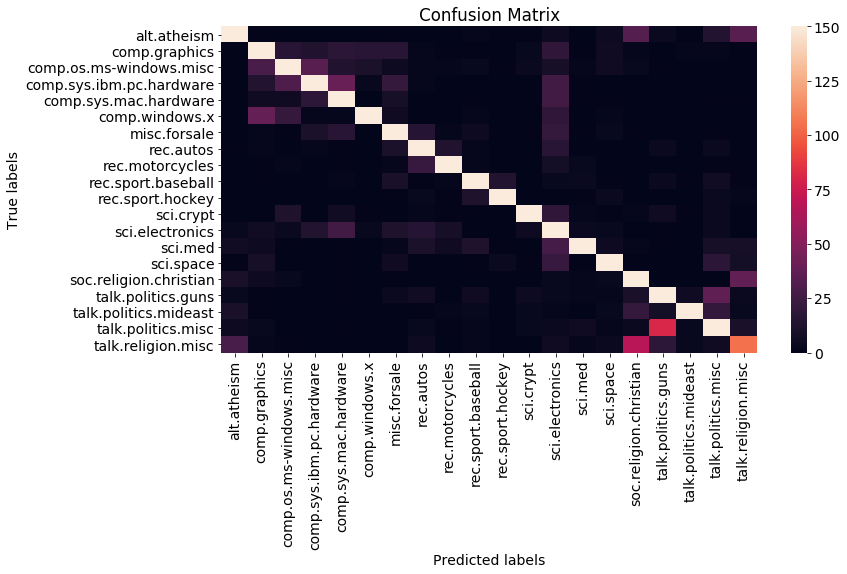

In [106]:
import seaborn as sns

# confusion matrix
labels = train.target_names
_labels = list(set(train.target))
cm = confusion_matrix(test.target, y_pred, _labels)

ax = plt.subplot()
sns.heatmap(cm, annot=False, ax=ax, vmax=150);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels, rotation='vertical')
ax.yaxis.set_ticklabels(labels);

## Embeddings

Ok, so we have a model that can take a document and predict its label - but remember in the process we wanted to get out a meaningful transformation of our data to a smaller feature space - our embedding. This is where we can use the embedding network directly to give us some meaningful document 'features'.
 
Here we could train a simple model to do predictions with these features - like the one above but maybe it is a little less computationally intense. We could also use this embedding space to group similar documents making a simple content based recommendation system. Since it is in a smaller, meaningful, dimensional space (here we are using a 128 dimensional embedding) we can do fairly quick lookups of similar items with a k nearest neighbors model (KNN).
 
Below we will build a simple knn on the embeddings to find similar documents in this space. But first, we will have a look at the embedding space with both PCA and TSNE, to get an idea of what the features are telling us - if anything informative.

In [0]:
embedded_train = embedding.predict(prepped_train)
embedded_test = embedding.predict(prepped_test)

7 features captures 92% of the variance


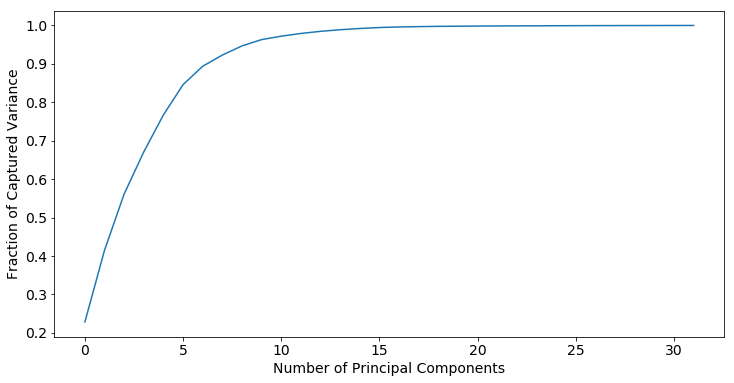

In [108]:
pca = PCA(n_components=32)
pca = pca.fit(embedded_train)

cum_var = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure('variance explanation')
ax = fig.add_subplot(111)
ax.plot(cum_var)
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Fraction of Captured Variance')

n_components = 7
print(f'{n_components} features captures {cum_var[n_components] * 100:0.0f}% of the variance')

In the plots below we can see that our embeddings very clearly find 'categories' and in particular the PCA plot seems to show directions for each category (fanning out in many directions). I'd imagine being on one of those lines means you are in that category and possibly where you lie outside of that could indicate sub feature level categories.

Text(0, 0.5, 'Data Project onto PC 2')

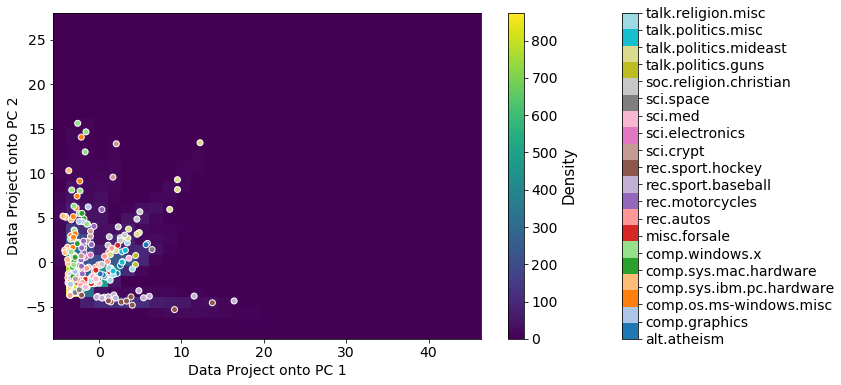

In [109]:
embedding_pcs = pca.transform(embedded_train)

pc_x = 0
pc_y = 1

fig, ax = plt.subplots()
density_map = ax.hist2d(
    embedding_pcs[:, pc_x],
    embedding_pcs[:, pc_y],
    bins=31,
    cmap="viridis"
)
every_n = 50  # take every nth image and label to plot over the sensity map
scat = ax.scatter(
    embedding_pcs[::every_n, pc_x],
    embedding_pcs[::every_n, pc_y],
    c=train.target[::every_n],
    cmap="tab20",
    edgecolor="w",
    linewidths=1
)
cbar = fig.colorbar(scat, ticks=np.arange(len(train.target_names)))
cbar.ax.set_label("Category")
cbar.ax.set_yticklabels(train.target_names)
fig.colorbar(density_map[3]).set_label("Density", fontsize=15)
ax.set_xlabel(f'Data Project onto PC {pc_x + 1}')
ax.set_ylabel(f'Data Project onto PC {pc_y + 1}')

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(embedded_train)

Text(0, 0.5, 'TSNE Component 2')

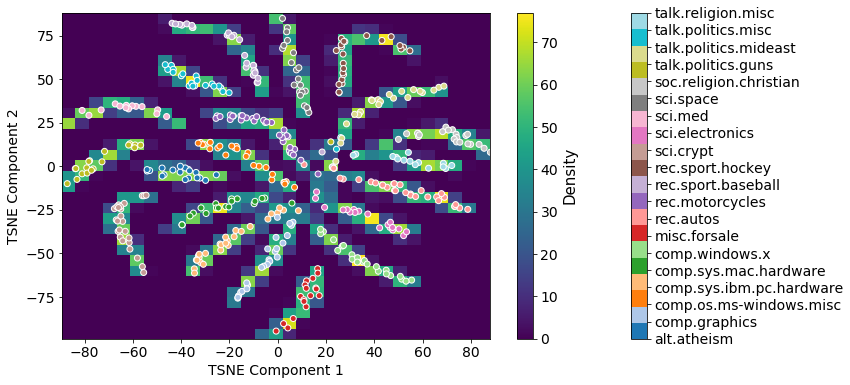

In [111]:
pc_x = 0
pc_y = 1

fig, ax = plt.subplots()
density_map = ax.hist2d(
    X_embedded[:, pc_x],
    X_embedded[:, pc_y],
    bins=31,
    cmap="viridis"
)
every_n = 25  # take every nth image and label to plot over the sensity map
scat = ax.scatter(
    X_embedded[::every_n, pc_x],
    X_embedded[::every_n, pc_y],
    c=train.target[::every_n],
    cmap="tab20",
    edgecolor="w",
    linewidths=1
)
cbar = fig.colorbar(scat, ticks=np.arange(len(train.target_names)))
cbar.ax.set_label("Category")
cbar.ax.set_yticklabels(train.target_names)
fig.colorbar(density_map[3]).set_label("Density", fontsize=15)
ax.set_xlabel(f'TSNE Component {pc_x + 1}')
ax.set_ylabel(f'TSNE Component {pc_y + 1}')

### Recommendations via Embeddings

As mentioned above, we can use the embeddings for more than just the model. We can create other models using the learned features. Here we will use a nearest neighbor model to find recommendations of similar articles. Depending on your training cadence this could be more or less up to date for your rec system, something you can think about with engineering.
 
Let's pick a document or two and look at the most similar docs found in the embedding space.

In [112]:
knn = NearestNeighbors(metric="cosine")
knn.fit(embedded_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
dist, ind = knn.kneighbors(embedded_test)

In [114]:
dist.shape, embedded_test.shape, embedded_train.shape

((7532, 5), (7532, 32), (11314, 32))

In [0]:
def print_sample(idx=1, n=1):
    cdist = dist[idx]
    cind = ind[idx]

    print(f"Distances {cdist[:n]}")
    print(f"Target: {test.target_names[test.target[idx]]}")
    print("# ##################################### #")
    print("Document")
    print(test.data[idx])

    for i in cind[:n]:
        print(f"Target: {train.target_names[train.target[i]]}")
        print("# ##################################### #")
        print("Similar Document")
        print(train.data[i])


In [121]:
names = np.array(test.target_names)[test.target]
idx = names == "rec.sport.baseball"
print(np.where(idx))

(array([  23,   28,   92,  120,  141,  167,  227,  229,  241,  273,  312,
        333,  356,  386,  393,  436,  463,  493,  496,  537,  538,  541,
        566,  576,  593,  617,  635,  642,  671,  675,  683,  721,  729,
        733,  754,  773,  779,  821,  848,  857,  885,  886,  928,  947,
        980,  990, 1007, 1030, 1041, 1045, 1049, 1072, 1074, 1115, 1152,
       1182, 1192, 1204, 1266, 1276, 1279, 1281, 1309, 1355, 1363, 1387,
       1388, 1402, 1431, 1479, 1503, 1543, 1557, 1561, 1598, 1613, 1623,
       1627, 1634, 1642, 1658, 1664, 1671, 1686, 1718, 1831, 1836, 1844,
       1876, 1905, 1915, 1917, 1928, 1942, 1945, 1972, 1995, 2025, 2026,
       2046, 2090, 2098, 2101, 2106, 2127, 2158, 2170, 2178, 2199, 2262,
       2274, 2275, 2296, 2327, 2353, 2359, 2389, 2407, 2418, 2431, 2456,
       2462, 2467, 2518, 2553, 2559, 2563, 2564, 2599, 2628, 2649, 2653,
       2674, 2684, 2693, 2711, 2718, 2721, 2749, 2800, 2805, 2835, 2848,
       2851, 2882, 2890, 2901, 2910, 2912, 2938, 2

In [132]:
 print_sample(7472, 1)

Distances [0.01426834]
Target: rec.sport.baseball
# ##################################### #
Document
In article <2943640103.10.p00421@psilink.com> "Dennis G Parslow" <p00421@psilink.com> writes:
>>FROM:   Dan Campbell <dan_c@jhunix.hcf.jhu.edu>
>>In article <1993Apr11.025636.1@ulkyvx.louisville.edu> pjtier01@ulkyvx.louisville.edu writes:
>>>In article <Apr.10.09.33.33.1993.28038@pilot.njin.net>, gajarsky@pilot.njin.net (Bob Gajarsky - Hobokenite) writes:

>>>> here's the hard working black players - none.
>>>> here's the lazy white players. - mcreynolds.

>>>Now that time has passed, what would the posts be like if Rickey were driving
>>>his boat drunk, killing himself and one of his teammates?  What would people
>>>say if Bonds, drunk out of his skull, smashed his car into a tree disabling
>>>himself &, say, Willie McGee for the season?  I can tell you.  They would be
>>>considered spoiled, lazy (say it) niggers.  

>>	This awfully presumptious of you, to assume you can read our minds

In summary, in this post we have created a neural network that can classify the content of text, and further, presented an architecture that produces features that can be used in other models or for content recommendation.